In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from datetime import timedelta

plt.style.use("dark_background")
np.random.seed(42)

## Análisis del test A/B

**Objetivo de esta sección:** Realizar un *end‑to‑end* del análisis de un experimento A/B.

**Pasos clave:**
1. Visualizar métricas acumuladas para entender la dinámica temporal.
2. Calcular métricas operativas (conversión, AOV) y detectar anomalías.
3. Aplicar pruebas estadísticas adecuadas (proporciones para conversión; Mann‑Whitney para montos).
4. Tomar una decisión basada en evidencia.

Cada subsección explica *qué* mide la métrica, *por qué* es relevante y *cómo* interpretarla.

### 3.1 Ingreso acumulado por grupo

**Qué haremos:** Graficar el ingreso acumulado de cada grupo día a día.

**Por qué:** El crecimiento divergente puede indicar un efecto positivo de la variante.

**Cómo:** Agrupamos por fecha y aplicamos `cumsum()` para obtener la curva acumulativa.

In [34]:
orders_df = pd.read_csv("orders_us.csv")
visits_df = pd.read_csv("visits_us.csv")

In [35]:
orders_df.head()

,transactionId,visitorId,date,revenue,group
0,1,1243327,2021-01-01,151.59,A
1,2,1857231,2021-01-01,269.31,A
2,3,1879007,2021-01-01,277.81,A
3,4,1367895,2021-01-01,953.00,A
4,5,1355549,2021-01-01,495.76,A


In [36]:
# Preprocesamiento
orders_df['date'] = pd.to_datetime(orders_df['date'])
visits_df['date'] = pd.to_datetime(visits_df['date'])

# 1. Métricas acumuladas

In [37]:
# 1) Sumar ingresos por día y grupo
daily = orders_df.groupby(['group', 'date'], as_index=False)['revenue'].sum()

# 2) Ordenar cronológicamente dentro de cada grupo
daily = daily.sort_values(['group', 'date'])

# 3) Acumulado por grupo
daily['cumulative_revenue'] = daily.groupby('group')['revenue'].cumsum()

# Resultado final
cumulative_revenue = daily
cumulative_revenue.head()

,group,date,revenue,cumulative_revenue
0,A,2021-01-01,13223.29,13223.29
1,A,2021-01-02,12997.94,26221.23
2,A,2021-01-03,21765.31,47986.54
3,A,2021-01-04,16498.81,64485.35
4,A,2021-01-05,13425.71,77911.06


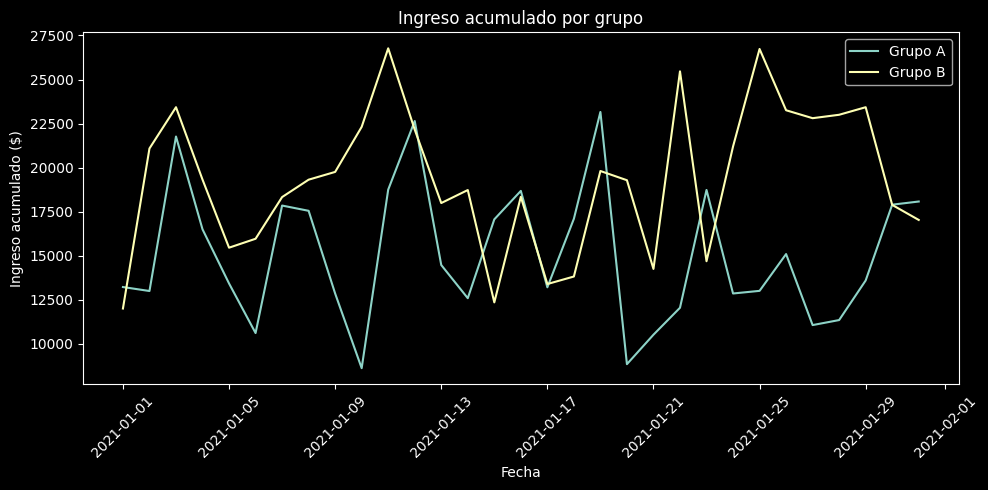

In [38]:
plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    grp_data = cumulative_revenue[cumulative_revenue['group']==grp]
    plt.plot(grp_data['date'], grp_data['revenue'], label=f'Grupo {grp}')
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

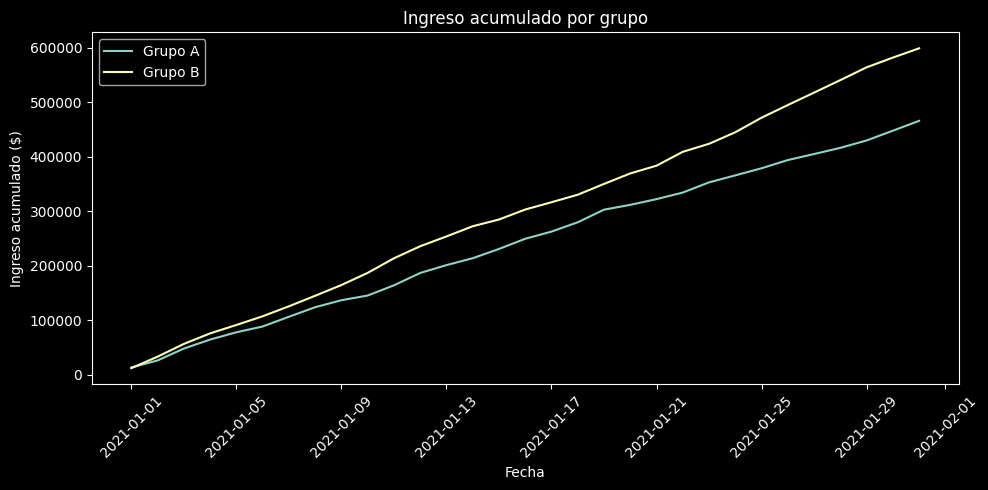

In [39]:
plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    grp_data = cumulative_revenue[cumulative_revenue['group']==grp]
    plt.plot(grp_data['date'], grp_data['cumulative_revenue'], label=f'Grupo {grp}')
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos observar la evolución del ingreso a lo largo de la prueba y detectar si uno de los grupos genera ingresos consistentemente mayores.

### 3.2 Tamaño de pedido promedio acumulado por grupo

**Qué haremos:** Analizar el *Average Order Value* (AOV) acumulado.

**Por qué:** Ayuda a entender si los grupos difieren en el tamaño de los pedidos, factor clave de revenue.

**Cómo:** Calculamos la media diaria y aplicamos `cummean()`.

In [40]:
# 1) Sumar ingresos por día y grupo
daily = orders_df.groupby(['group', 'date'], as_index=False)['revenue'].mean()

# 2) Ordenar cronológicamente dentro de cada grupo
daily = daily.sort_values(['group', 'date'])

# 3) Calcular acumulado por grupo (media expandida)
daily['AOV_cum'] = (
    daily.groupby('group')['revenue']
         .transform(lambda x: x.expanding().mean())
)

# Resultado final
avg_order = daily

In [41]:
avg_order.head()

,group,date,revenue,AOV_cum
0,A,2021-01-01,528.931600,528.931600
1,A,2021-01-02,565.127826,547.029713
2,A,2021-01-03,777.332500,623.797309
3,A,2021-01-04,589.243214,615.158785
4,A,2021-01-05,406.839697,573.494967


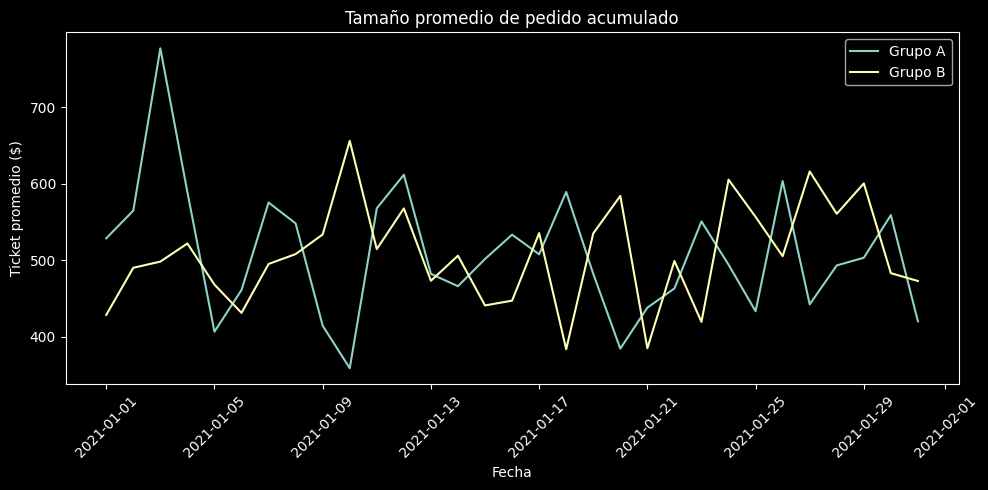

In [42]:
# gráfico
plt.figure(figsize=(10,5))
for g in ['A', 'B']:
    mask = avg_order['group'] == g
    plt.plot(avg_order.loc[mask, 'date'], avg_order.loc[mask, 'revenue'], label=f'Grupo {g}')
plt.title('Tamaño promedio de pedido acumulado')
plt.xlabel('Fecha'); plt.ylabel('Ticket promedio ($)')
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


Analizamos si el ticket promedio difiere significativamente entre grupos.

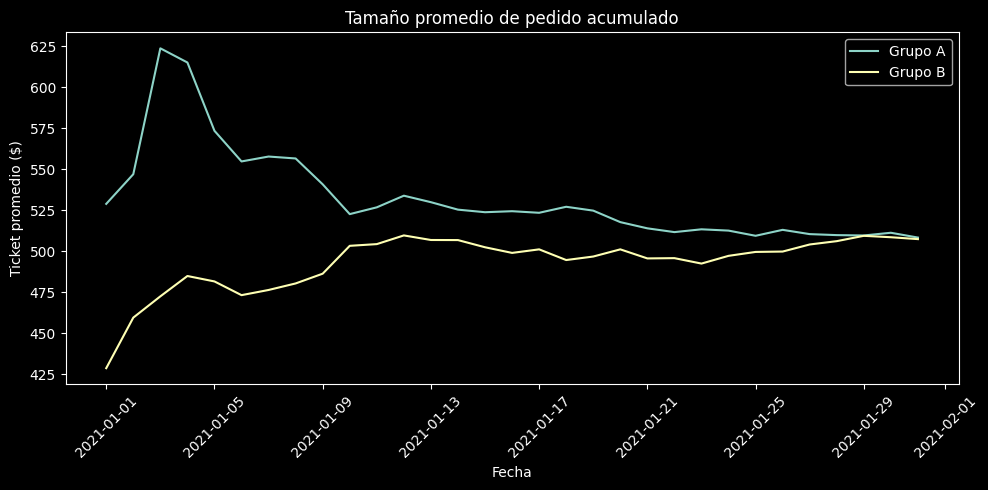

In [43]:
# gráfico
plt.figure(figsize=(10,5))
for g in ['A', 'B']:
    mask = avg_order['group'] == g
    plt.plot(avg_order.loc[mask, 'date'], avg_order.loc[mask, 'AOV_cum'], label=f'Grupo {g}')
plt.title('Tamaño promedio de pedido acumulado')
plt.xlabel('Fecha'); plt.ylabel('Ticket promedio ($)')
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

### 3.3 Diferencia relativa del ticket promedio (B vs A)

**Qué haremos:** Medir la diferencia relativa de AOV entre B y A.

**Por qué:** Una métrica normalizada facilita ver ventaja percentual.

**Cómo:** Calculamos `(B - A)/A` día a día.

In [44]:
merged_avg = (
    avg_order.pivot(index='date', columns='group', values='revenue')
    .reset_index()
)

merged_avg.head()

group,date,A,B
0,2021-01-01,528.931600,428.723571
1,2021-01-02,565.127826,490.387442
2,2021-01-03,777.332500,498.480000
3,2021-01-04,589.243214,522.149730
4,2021-01-05,406.839697,468.375152


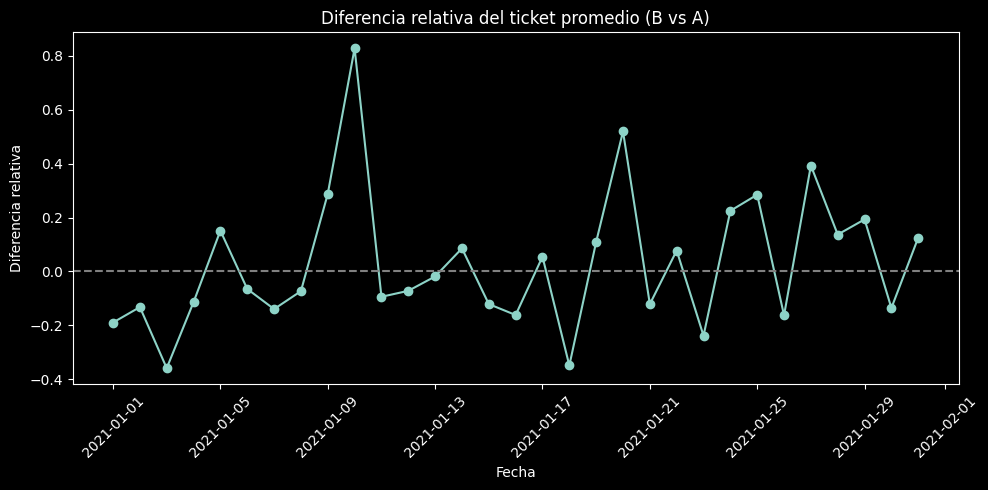

In [45]:
merged_avg['rel_diff'] = (merged_avg['B'] - merged_avg['A']) / merged_avg['A']

plt.figure(figsize=(10,5))
plt.plot(merged_avg['date'], merged_avg['rel_diff'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Diferencia relativa del ticket promedio (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Una diferencia estable y positiva indicaría que B tiene un ticket promedio mayor.

### 3.4 Tasa de conversión diaria

**Qué haremos:** Calcular la tasa de conversión diaria.

**Por qué:** Conversion Rate (CR) es el KPI principal de muchos e‑commerce.

**Cómo:** `CR = pedidos / visitas` por grupo y fecha.

In [46]:
# Pedidos por día y grupo
orders_per_day = orders_df.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day.rename(columns={'transactionId':'orders'}, inplace=True)

orders_per_day.head()

,group,date,orders
0,A,2021-01-01,25
1,A,2021-01-02,23
2,A,2021-01-03,28
3,A,2021-01-04,28
4,A,2021-01-05,33


In [47]:
# Unimos con visits
daily = pd.merge(visits_df, orders_per_day, on=['group','date'], how='left').fillna(0)
daily['conversion'] = daily['orders'] / daily['visits']

daily.head()

,date,group,visits,orders,conversion
0,2021-01-01,A,1022,25,0.024462
1,2021-01-01,B,1038,28,0.026975
2,2021-01-02,A,967,23,0.023785
3,2021-01-02,B,1003,43,0.042871
4,2021-01-03,A,1038,28,0.026975


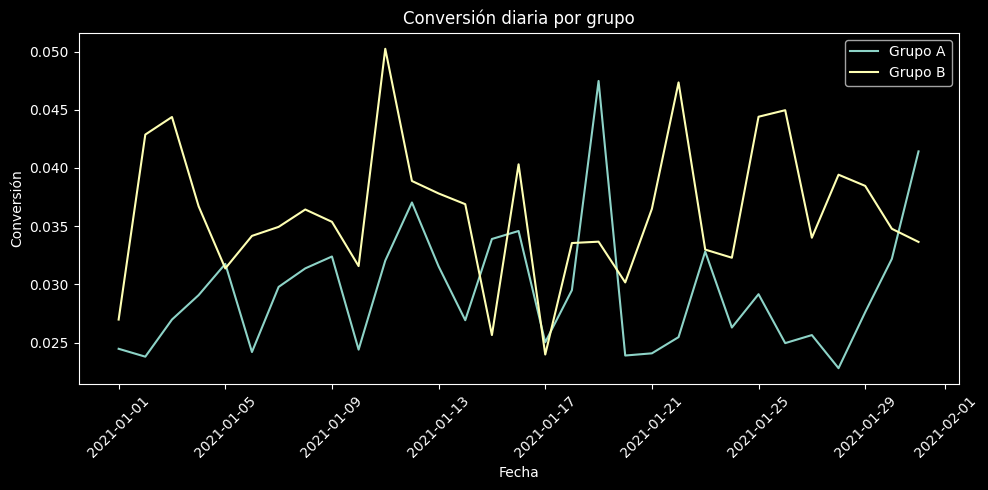

In [48]:
plt.figure(figsize=(10,5))
for grp in ['A','B']:
    grp_data = daily[daily['group']==grp]
    plt.plot(grp_data['date'], grp_data['conversion'], label=f'Grupo {grp}')
plt.title('Conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Conversión')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comparamos curvas para detectar diferencias notorias en la tasa de conversión.

### 3.5 Número de pedidos por usuario

**Qué haremos:** Visualizar la distribución de pedidos por usuario.

**Por qué:** Usuarios con muchos pedidos pueden sesgar la conversión.

**Cómo:** `groupby` sobre `visitorId` y dispersión para detectar heavy buyers.

In [49]:
orders_per_user = orders_df.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_per_user.rename(columns={'transactionId':'orders'}, inplace=True)

orders_per_user.head()

,visitorId,orders
0,1000140,1
1,1000384,1
2,1000517,1
3,1000933,1
4,1001236,1


<Axes: ylabel='Frequency'>

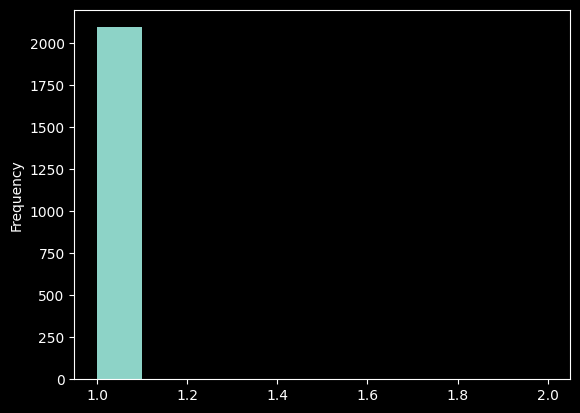

In [50]:
orders_per_user['orders'].plot(kind='hist')

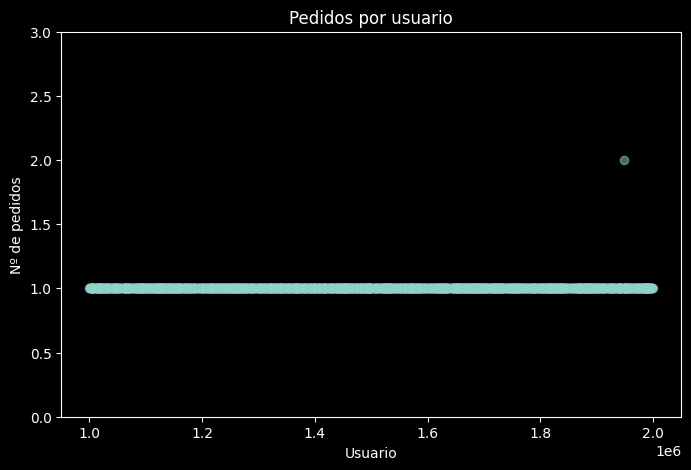

In [51]:
plt.figure(figsize=(8,5))
plt.scatter(orders_per_user['visitorId'], orders_per_user['orders'], alpha=0.5)
plt.title('Pedidos por usuario')
plt.xlabel('Usuario')
plt.ylabel('Nº de pedidos')
plt.ylim(0, orders_per_user['orders'].max()+1)
plt.show()

In [52]:
q95_orders = np.percentile(orders_per_user['orders'], 95)
q99_orders = np.percentile(orders_per_user['orders'], 99)
print(f'Percentil 95: {q95_orders}, Percentil 99: {q99_orders}')

Percentil 95: 1.0, Percentil 99: 1.0


Generalmente consideramos valores por encima del percentil 99 como anomalías.

### 3.6 Precios de pedidos

**Qué haremos:** Examinar la dispersión de montos por pedido.

**Por qué:** Detecta outliers de ingreso que pueden distorsionar el ticket promedio.

**Cómo:** Percentiles 95/99 guían el filtro de valores extremos.

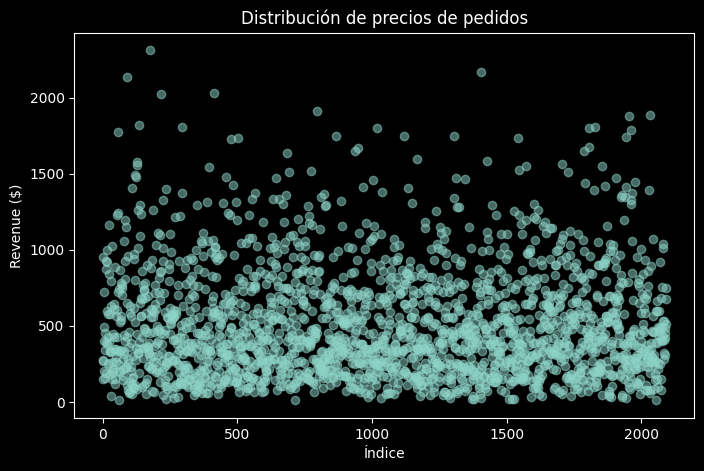

In [53]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(orders_df)), orders_df['revenue'], alpha=0.5)
plt.title('Distribución de precios de pedidos')
plt.xlabel('Índice')
plt.ylabel('Revenue ($)')
plt.show()

<Axes: ylabel='Frequency'>

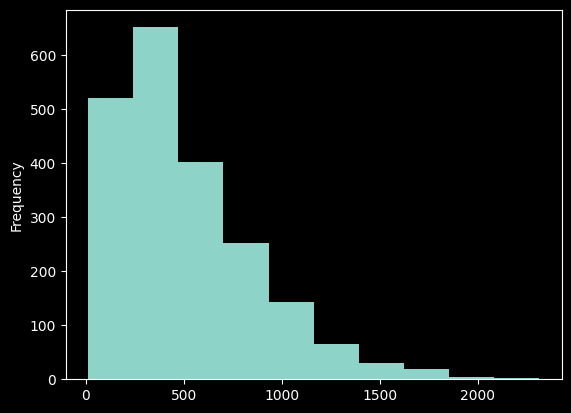

In [54]:
orders_df['revenue'].plot(kind='hist')

In [55]:
q95_rev = np.percentile(orders_df['revenue'], 95)
q99_rev = np.percentile(orders_df['revenue'], 99)
print(f'Percentil 95: {q95_rev:.2f}, Percentil 99: {q99_rev:.2f}')

Percentil 95: 1218.78, Percentil 99: 1728.12


Definimos el umbral de anomalía de precio en el percentil 99.

### 3.7 Significancia estadística (conversión, datos crudos)

**Qué haremos:** Probar la diferencia de conversión con datos sin filtrar.

**Por qué:** Nos da la primera indicación de significancia.

**Cómo:** Usamos `proportions_ztest` para dos proporciones.

In [72]:
conversions = daily.groupby('group').agg({'orders':'sum', 'visits':'sum'})
success = conversions['orders']
trials = conversions['visits']
conversions

,orders,visits
group,,
A,915,31044
B,1179,32548


In [71]:
stat, pval = proportions_ztest(success, trials)
print(f'Estadístico z: {stat:.4f}, p-valor: {pval:.4f}')

Estadístico z: -4.7674, p-valor: 0.0000


Un p-valor < 0.05 indica diferencia significativa en la conversión.

### 3.8 Significancia estadística (ticket promedio, datos crudos)

**Qué haremos:** Comprobar si el ticket promedio difiere.

**Por qué:** Cantidades monetarias raramente son normales; Mann‑Whitney es robusto.

**Cómo:** Prueba no paramétrica `mannwhitneyu`.

In [73]:
a_revenue = orders_df[orders_df['group']=='A']['revenue']
b_revenue = orders_df[orders_df['group']=='B']['revenue']

u_stat, pval_rev = stats.mannwhitneyu(a_revenue, b_revenue, alternative='two-sided')
print(f'U estadístico: {u_stat}, p-valor: {pval_rev:.4f}')

U estadístico: 530718.5, p-valor: 0.5274


### 3.9 Filtrado de valores atípicos

**Qué haremos:** Repetir el análisis tras eliminar outliers.

**Por qué:** Outliers pueden inflar varianza y ocultar significancia.

**Cómo:** Filtramos usuarios >Q99 pedidos o revenue >Q99.

In [61]:
# Umbrales
orders_threshold = q99_orders
revenue_threshold = q99_rev

print("1", orders_threshold)
print("2", revenue_threshold)

1 1.0
2 1728.1160000000007


In [62]:
# Extraer usuarios con pedidos anómalos
abnormal_users = orders_per_user[orders_per_user['orders'] > orders_threshold]['visitorId']
filtered_orders = orders_df[~orders_df['visitorId'].isin(abnormal_users) & (orders_df['revenue'] <= revenue_threshold)]

In [63]:
abnormal_users

1975    1948178
Name: visitorId, dtype: int64

In [64]:
filtered_orders

,transactionId,visitorId,date,revenue,group
0,1,1243327,2021-01-01,151.59,A
1,2,1857231,2021-01-01,269.31,A
2,3,1879007,2021-01-01,277.81,A
3,4,1367895,2021-01-01,953.00,A
4,5,1355549,2021-01-01,495.76,A
...,...,...,...,...,...
2089,2090,1764140,2021-01-31,417.81,B
2090,2091,1836066,2021-01-31,311.10,B
2091,2092,1594673,2021-01-31,748.05,B
2092,2093,1543605,2021-01-31,676.82,B


In [65]:
# Recalcular diarios con datos filtrados
orders_per_day_f = filtered_orders.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day_f.rename(columns={'transactionId':'orders'}, inplace=True)
daily_f = pd.merge(visits_df, orders_per_day_f, on=['group','date'], how='left').fillna(0)
daily_f['conversion'] = daily_f['orders'] / daily_f['visits']

In [66]:
daily_f

,date,group,visits,orders,conversion
0,2021-01-01,A,1022,25,0.024462
1,2021-01-01,B,1038,28,0.026975
2,2021-01-02,A,967,22,0.022751
3,2021-01-02,B,1003,42,0.041874
4,2021-01-03,A,1038,27,0.026012
...,...,...,...,...,...
57,2021-01-29,B,1014,38,0.037475
58,2021-01-30,A,994,30,0.030181
59,2021-01-30,B,1064,37,0.034774
60,2021-01-31,A,1038,42,0.040462


In [67]:
conversions_f = daily_f.groupby('group').agg({'orders':'sum', 'visits':'sum'})
stat_f, pval_f = proportions_ztest(conversions_f['orders'], conversions_f['visits'])
print(f'Conversión filtrada - z: {stat_f:.4f}, p-valor: {pval_f:.4f}')

Conversión filtrada - z: -4.7827, p-valor: 0.0000


In [68]:
a_rev_f = filtered_orders[filtered_orders['group']=='A']['revenue']
b_rev_f = filtered_orders[filtered_orders['group']=='B']['revenue']
u_stat_f, pval_rev_f = stats.mannwhitneyu(a_rev_f, b_rev_f, alternative='two-sided')
print(f'Ticket promedio filtrado - U: {u_stat_f}, p-valor: {pval_rev_f:.4f}')

Ticket promedio filtrado - U: 517439.0, p-valor: 0.4567


### 3.10 Conclusiones y decisión final

**Qué haremos:** Graficar el ingreso acumulado de cada grupo día a día.

**Por qué:** El crecimiento divergente puede indicar un efecto positivo de la variante.

**Cómo:** Agrupamos por fecha y aplicamos `cumsum()` para obtener la curva acumulativa.

Basados en los análisis anteriores:
- **Conversión**: evaluamos p-valores crudos y filtrados.
- **Ticket promedio**: idem.

Si ambos indicadores muestran una mejora significativa (p < 0.05) para el grupo B, se podría considerar a B como ganador y detener la prueba. Si no hay diferencia significativa o los resultados son contradictorios, recomendamos continuar o parar concluyendo que no hay diferencias.